# Set up


> setwd("/users/genomics/xoel/codebases/co_new/results/")

> plotdir <- "Plots/"

> dir.create(plotdir, showWarnings = F)

> library(ggplot2)

> library(ggh4x)

> library(ggpubr)

> library(ggrepel)

> library(tidyr)

> library(dplyr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





> fig <- function(width, heigth) {
+     options(repr.plot.width = width, repr.plot.height = heigth)
+ }

> CellTypeAnnot <- c("vRG E", "vRG L", "tRG", "oRG E", 
+     "oRG L", "nIPC", "Neu E", "GluN3", "GluN1", "GluN2", "GluN7", 
+     "GluN5", "GluN4", " ..." ... [TRUNCATED] 

> CellTypeOrder <- c("RGC", "vRG", "vtRG", "oRG", "RG E", 
+     "RG L", "vRG E", "vRG L", "tRG", "oRG E", "oRG L", "Neural", 
+     "GluN", "nIPC", " ..." ... [TRUNCATED] 

> CellTypeLabels <- CellTypeOrder

> CellTypeColor <- setNames(c("#bec1d4", "#7d87b9", 
+     "#023fa5", "#d6bcc0", "#bb7784", "#8e063b", "#b5bbe3", "#8595e1", 
+     "#4a6fe3", "#e6afb ..." ... [TRUNCATED] 

> ctinfo <- data.frame(hex = CellTypeColor, Name = factor(names(CellTypeColor))) %>% 
+     mutate(`Common label` = Name)

> plot.celltype <- ggplot(data = ctinfo, mapping = aes(x = 0, 
+     y = Name, fill = `Common label`)) + geom_tile() + scale_fill_manual(values = Cell .... [TRUNCATED] 

> plot.celltype

> write.csv(ctinfo, file =

[1] "none"             "Ultra peripheral" "Peripheral"       "Connector"       
[5] "Kinless"          "Provincial Hub"   "Connector Hub"    "Kinless Hub"

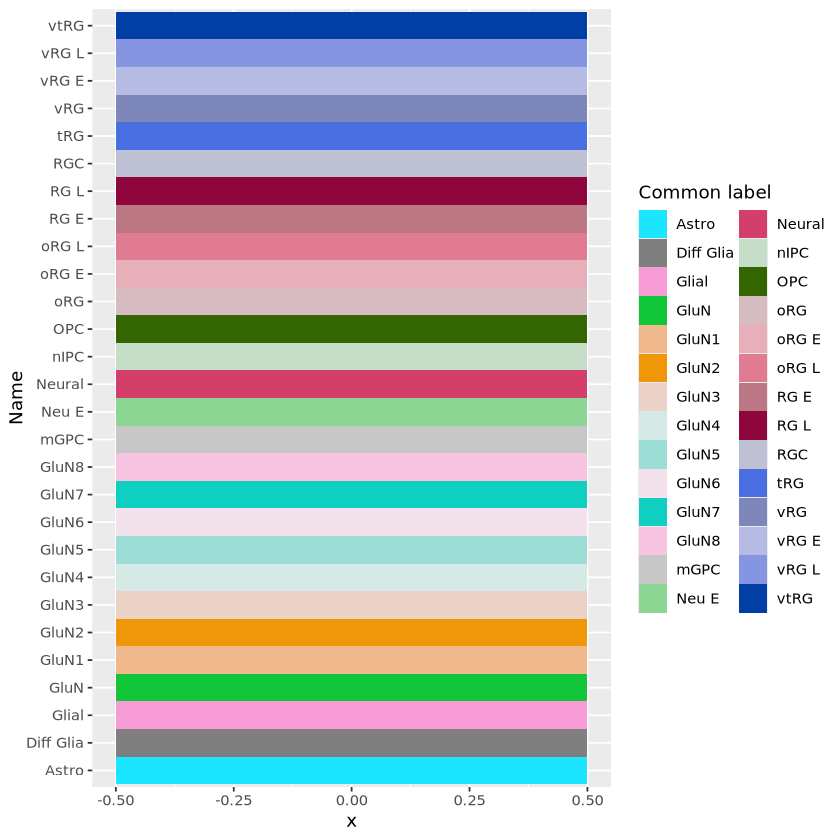

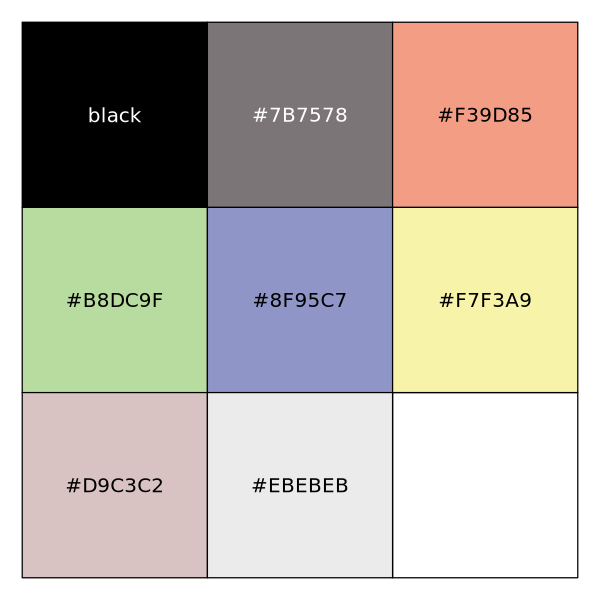

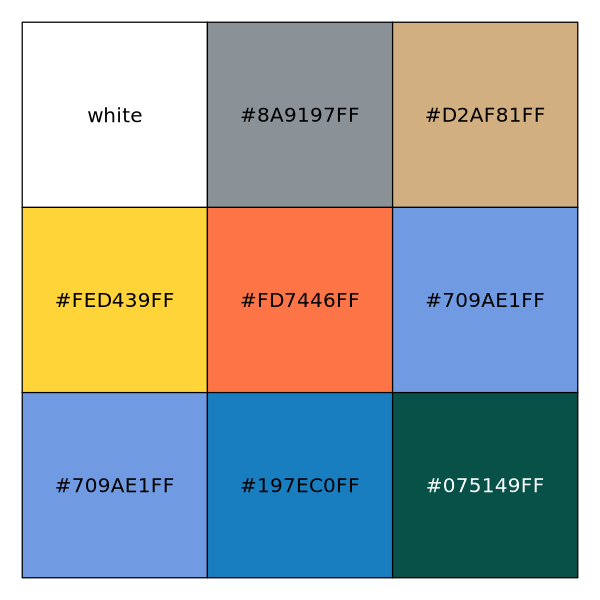

In [ ]:
# Path to the R script containing common functions and color definitions
config_script_path <- '/users/genomics/xoel/codebases/co_new/src/0_Rplots.R'
source(config_script_path, echo=T)

fig(5,5)
names(RoleColors)
scales::show_col(RoleColors)
RoleColorsNew <- setNames(
    c('white', ggsci::pal_simpsons()(16)[c(3,4,1,5,2,7,12)]),
    names(RoleColors))
RoleColorsNew['Peripheral Hub'] <- RoleColorsNew['Provincial Hub']
RoleColorsNew <- RoleColorsNew[
    c('none','Ultra peripheral','Peripheral','Connector','Kinless',
      'Peripheral Hub','Provincial Hub','Connector Hub','Kinless Hub')]
scales::show_col(RoleColorsNew)


In [2]:
n.cores <- Sys.getenv('SLURM_CPUS_PER_TASK')
if(!is.numeric(n.cores)){
    n.cores <- as.numeric(n.cores)
} else {
    n.cores <- parallel::detectCores()
}
n.cores

[1] 48

In [3]:
style <- function(p, major.x = F, major.y = T){
    p <- p + 
    theme_light() +
    ggpubr::labs_pubr() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5), 
          panel.grid.minor = element_blank(),
          panel.grid.major = element_blank(),
          strip.placement = 'outside',
          strip.text = element_text(color = 'black', angle=0),
          strip.background = element_rect(fill='#DDDDDD', color = 'transparent'),
          panel.spacing.y = unit(1, 'mm'),
          panel.spacing.x = unit(3, 'mm'),
          panel.border = element_rect(fill='transparent', color = 'black', linewidth = 1))

    if (major.x){
        p <- p + theme(panel.grid.major.x = element_line(color = 'darkgrey', linewidth  = .2))
    }
    if (major.y){
        p <- p + theme(panel.grid.major.y = element_line(color = 'darkgrey', linewidth  = .2))
    }
    p
}

In [4]:
score.comparison <- function(scores.df, type = 'violin', 
                             color = 'black', linewidth = 0.2, 
                             boxplot.outliers = F, boxplot.fill = 'white',
                             barplot.position = 'stack', barplot.palette = NULL){
    fig(12,17)

    p <- ggplot(scores.df, aes(x = cell.type, y = value, fill = cell.type)) + 
    labs(x = 'Lineage & Cell type', color='Cell type', y = 'GRN score') +
    facet_grid(rows=vars(variable), cols = vars(Sample), scales ='free', space = 'free_x', switch = 'y')+ 
    scale_fill_manual(values = CellTypeColor)
    
    if (type == 'violin'){
        p <- p + geom_violin(color = 'black', linewidth = 0.2) +
            geom_boxplot(color = color, linewidth = linewidth, outliers = boxplot.outliers, fill = boxplot.fill, alpha = 0.5, width = .25)
    } else if (type == 'barplot'){
        fig(12,6)
        p <- p + geom_bar(color = color, linewidth = linewidth, 
                          position = barplot.position,
                          mapping = aes(x = cell.type, fill = value), inherit.aes = F) + 
            scale_fill_manual(name = 'Category', values = barplot.palette) + 
            scale_y_continuous(expand = expansion(mult = c(0,0)), labels = if(barplot.position == 'fill'){scales::label_percent()}else{NULL})
    } else {
        p <- p + geom_boxplot(color = color, linewidth = linewidth, outliers = boxplot.outliers)
    } 
    return(style(p) + theme(panel.spacing.y = unit(3, 'mm')))
}

In [5]:
SampleOrder <- c('Gliogenesis','NeuralPCW20','NeuralPCW21','NeuralPCW24')

# List of TFs  
We might want to focus on the dynamics of TFs.

In [ ]:
# Path to the CSV file containing the list of human transcription factors
tf_list_path <- '/projects_ng/HumanTFs/DatabaseExtract_v_1.01.csv'
tf.geneset <- data.table::fread(tf_list_path, nThread=n.cores, data.table=F)[,-1] %>% subset(grepl('Yes', `Is TF?`)) %>% select(`HGNC symbol`) %>% unlist %>% gsub(pattern=' ', replacement = '', fixed=T) %>%unique %>% sort()

# Transcriptomic complexity GRNs  
By comparison of different network scores already computed during CellOracle's pipeline

In [7]:
# First melt the dataframe so that we have one line per variable and observation
scores.df <- reshape2::melt(NetworkScores, id.vars = c('is.source', 'Gene', 'cell.type', 'Sample', 'SampleLabel')) %>%
subset((!variable%in%c('role', 'Role name', 'module')) &  (Sample %in% SampleOrder)) %>% 
mutate(value = as.numeric(value), 
       is.tf = Gene %in% tf.geneset)

In [ ]:
# Define output path for network scores plot (all genes)
network_scores_all_pdf <- '/users/genomics/xoel/Review_CD/centrality_comparison/network_scores.all_genes.v1.pdf'
cairo_pdf(network_scores_all_pdf, width = 12, height = 17, onefile = T)
score.comparison(scores.df)
score.comparison(scores.df, type = '')
dev.off()

# Define output path for network scores plot (source genes)
network_scores_source_pdf <- '/users/genomics/xoel/Review_CD/centrality_comparison/network_scores.source_genes.v1.pdf'
cairo_pdf(network_scores_source_pdf, width = 12, height = 17, onefile = T)
score.comparison(subset(scores.df, is.source))
score.comparison(subset(scores.df, is.source), type = '')
dev.off()

# Define output path for network scores plot (TF genes)
network_scores_tf_pdf <- '/users/genomics/xoel/Review_CD/centrality_comparison/network_scores.TF_genes.v1.pdf'
cairo_pdf(network_scores_tf_pdf, width = 12, height = 17, onefile = T)
score.comparison(subset(scores.df, is.tf))
score.comparison(subset(scores.df, is.tf), type = '')
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

In [9]:
# First melt the dataframe so that we have one line per variable and observation
scores.df2 <- reshape2::melt(NetworkScores, id.vars = c('is.source', 'Gene', 'cell.type', 'Sample', 'SampleLabel')) %>%
subset((variable%in%c('Role name', 'module')) &  (Sample %in% SampleOrder)) %>% 
mutate(value = as.character(value), 
       is.tf = Gene %in% tf.geneset)
# define all possible values
module.levels <- subset(scores.df2, variable == 'module')$value %>% unique %>% as.numeric %>% sort %>% as.character
module.colors <- setNames(viridis::turbo(n = length(module.levels)+2)[-c(1, length(module.levels))], nm = module.levels)
all.levels <- c(names(RoleColorsNew), module.levels)
all.colors <- c(RoleColorsNew, module.colors)

hub.values <- grep(names(RoleColorsNew), pattern = 'Hub', value =T)
scores.df2 <- scores.df2 %>% mutate(value = factor(value, levels = all.levels),
                                    variable = ifelse(value %in% hub.values, 'Hub roles', as.character(variable)),
                                    variable = gsub('Role name', replacement = 'Non-hub roles', fixed = T, x = variable),
                                    variable = gsub('module', replacement = 'GRN module', fixed = T, x = variable)
                                    )

In [ ]:
# Define output path for network scores plot (module/role, all genes)
network_scores_module_role_all_pdf <- '/users/genomics/xoel/Review_CD/centrality_comparison/network_scores.module_and_role.all_genes.v1.pdf'
cairo_pdf(network_scores_module_role_all_pdf, 
          width = 12, height = 8, onefile = T)
score.comparison(scores.df2, type = 'barplot', barplot.palette = all.colors)
score.comparison(scores.df2, type = 'barplot', barplot.palette = all.colors, barplot.position = 'fill')
dev.off()

# Define output path for network scores plot (module/role, TF genes)
network_scores_module_role_tf_pdf <- '/users/genomics/xoel/Review_CD/centrality_comparison/network_scores.module_and_role.TF_genes.v1.pdf'
cairo_pdf(network_scores_module_role_tf_pdf, 
          width = 12, height = 8, onefile = T)
score.comparison(subset(scores.df2, is.tf), type = 'barplot', barplot.palette = all.colors)
score.comparison(subset(scores.df2, is.tf), type = 'barplot', barplot.palette = all.colors, barplot.position = 'fill')
dev.off()

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


pdf 
  2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


pdf 
  2

# Transcriptomic complexity in scRNA-seq data  
Single-cell RNA sequencing (scRNA-seq) datasets provide a powerful means to explore transcriptomic complexity across individual cells. A typical scRNA-seq dataset consists of a cell-by-gene count matrix, where each element represents the expression level (counts) of a gene in a specific cell. Understanding transcriptomic complexity is key to uncovering biological diversity, cellular states, and regulatory mechanisms. 

This notebook outlines methods to quantify transcriptomic complexity from scRNA-seq data, with accompanying explanations, formulas, and example code snippets for implementation.

In [ ]:
# Base directory for input data (counts and metadata files)
input_data_dir <- '/users/genomics/xoel/Review_CD/centrality_comparison/'
# List of files in the base directory matching the pattern 'counts.csv'
datasets <- list.files(input_data_dir, pattern = 'counts.csv', full.names = T) 
# Set names for the list elements based on file names
datasets <- setNames(datasets, nm = datasets %>% basename %>% gsub(pattern = '.counts.csv', replacement = '', fixed = T))
# Order the datasets based on the predefined sample order
datasets <- datasets[SampleOrder]


In [12]:
# First, let's load the data we need
exp.mats <- list()
cell.metas <- list()

for (s in names(datasets)){
    message(s)
    counts.file <- datasets[s]
    metadata.file <- counts.file %>% gsub(pattern = '.counts.', replacement = '.metadata.', fixed=T)

    d <- data.table::fread(counts.file, nThread = n.cores, data.table = F, header = T)
    rownames(d) <- d[,1]
    d <- d[,-1]
    m <- data.table::fread(metadata.file, nThread = n.cores, data.table = F, header = T) 
    m <- m %>% mutate(CellType = factor(final.label, CellTypeOrder))

    exp.mats[[s]] <- d
    cell.metas[[s]] <- m
}


Gliogenesis

NeuralPCW20

NeuralPCW21

NeuralPCW24



---
## **1. Number of Genes Expressed per Cell**
- **Description:** The number of genes expressed above a certain threshold (e.g., counts > 0 or TPM/CPM > 1) in each cell.
- **Formula:** 
  \[
  N_{\text{genes expressed}} = \sum_{i} \mathbb{I}(x_i > \text{threshold})
  \]
  Where \( x_i \) is the count of gene \( i \), and \( \mathbb{I} \) is an indicator function.
- **Code:**
  ```python
  import numpy as np

  # Counts matrix: rows = cells, columns = genes
  counts_matrix = np.array([[...], [...], [...]])  # Replace with your data

  # Number of expressed genes per cell
  num_genes_expressed = (counts_matrix > 0).sum(axis=1)
  ```



In [ ]:
# number of genes expressed by cell:

measure.n.genes <- function(d, m, type = 'boxplot'){
    
    n.exp <- data.frame(V1 = rownames(d), n.genes = rowSums(d > 0))
    m <- merge(m, n.exp, by ='V1', all=T)
    
    if (!all(colSums(is.na(m[,c('final.label', 'n.genes')])) == 0 )){
        stop('Check the merging: it produced NA values in n.genes or final.label')
    }
    
    p <- ggplot(m, aes(fill = CellType, y = CellType, x = n.genes)) +
    scale_fill_manual(values = CellTypeColor)
    
    if (type == 'violin'){
        p <- p + geom_violin(color = 'black', linewidth = 0.2) +
            geom_boxplot(color = 'black', fill = 'white', alpha = 0.5, width = 0.25, linewidth = 0.2, outliers = F)
    } else {
        p <- p + geom_boxplot(color = 'black', linewidth = 0.2, outliers = F)
    } 
    
    return(list(plot = style(p), data = m))
}

---
## **2. Shannon Entropy**
- **Description:** Measures the uniformity of gene expression in each cell, reflecting transcript diversity.
- **Formula:** 
  \[
  H = - \sum_{i} p_i \log_2(p_i)
  \]
  Where \( p_i \) is the proportion of expression of gene \( i \) in a cell:
  \[
  p_i = \frac{x_i}{\sum_{j} x_j}
  \]
- **Code:**
  ```python
  # Calculate proportions for each gene in each cell
  proportions = counts_matrix / counts_matrix.sum(axis=1, keepdims=True)

  # Calculate entropy per cell
  entropy = -np.nansum(proportions * np.log2(proportions), axis=1)
  ```

In [ ]:
# number of genes expressed by cell:

measure.shannon.entropy <- function(d, m, type = 'boxplot'){

    
    props <- d/rowSums(d)
    pp <- props * log2(props)
    entropy <- data.frame(V1 = rownames(d), 
                          entropy = -rowSums(pp, na.rm = T))
    m <- merge(m, entropy, by ='V1', all=T)
    
    if (!all(colSums(is.na(m[,c('final.label', 'entropy')])) == 0 )){
        stop('Check the merging: it produced NA values in entropy or final.label')
    }
    
    p <- ggplot(m, aes(fill = CellType, y = CellType, x = entropy)) +
    scale_fill_manual(values = CellTypeColor)
    
    if (type == 'violin'){
        p <- p + geom_violin(color = 'black', linewidth = 0.2) +
            geom_boxplot(color = 'black', fill = 'white', alpha = 0.5, width = 0.25, linewidth = 0.2, outliers = F)
    } else {
        p <- p + geom_boxplot(color = 'black', linewidth = 0.2, outliers = F)
    } 
    
    return(list(plot = style(p), data = m))
}

---
## **3. Richness and Diversity Indices**
#### **~Richness~**
- **Description:** The total number of genes expressed above a certain threshold in a cell (similar to Method #1).
#### **Simpson's Diversity Index**
- **Description:** Reflects the probability that two randomly chosen counts belong to the same gene.
- **Formula:** 
  \[
  D = 1 - \sum_{i} p_i^2
  \]
- **Code:**
  ```python
  # Simpson's diversity index per cell
  simpson_diversity = 1 - np.sum(proportions ** 2, axis=1)
  ```

In [ ]:
# number of genes expressed by cell:

measure.simpsons.diversity <- function(d, m, type = 'boxplot'){

    
    props <- d/rowSums(d)
    diversity <- data.frame(V1 = rownames(d), 
                            diversity = 1-rowSums(props **2))
    m <- merge(m, diversity, by ='V1', all=T)
    
    if (!all(colSums(is.na(m[,c('final.label', 'diversity')])) == 0 )){
        stop('Check the merging: it produced NA values in diversity or final.label')
    }
    
    p <- ggplot(m, aes(fill = CellType, y = CellType, x = diversity)) +
    scale_fill_manual(values = CellTypeColor)
    
    if (type == 'violin'){
        p <- p + geom_violin(color = 'black', linewidth = 0.2) +
            geom_boxplot(color = 'black', fill = 'white', alpha = 0.5, width = 0.25, linewidth = 0.2, outliers = F)
    } else {
        p <- p + geom_boxplot(color = 'black', linewidth = 0.2, outliers = F)
    } 
    
    return(list(plot = style(p), data = m))
}

---

## **~4. Alternative Splicing~**
- **Description:** If isoform data is available, analyze the proportion of isoforms expressed per gene to assess transcript diversity.
- **Approach:** Use transcript-level quantifications from tools like Kallisto or Salmon to calculate entropy or richness metrics for isoforms.

---

## **5. Variability Analysis**
- **Description:** Examine inter- and intra-cellular variability in gene expression using metrics like the Coefficient of Variation (CV).
- **Formula:** 
  \[
  CV = \frac{\sigma}{\mu}
  \]
  Where \( \sigma \) is the standard deviation and \( \mu \) is the mean expression level of a gene across cells.

- **Code:**
  ```python
  # Mean and standard deviation of gene expression across cells
  gene_means = counts_matrix.mean(axis=0)
  gene_stds = counts_matrix.std(axis=0)

  # Coefficient of Variation
  cv = gene_stds / gene_means
  ```

In [ ]:
compute_cv <- function(d){
    colMeans(d) / apply(d, 2, sd)
}

measure.cv.in.groups <- function(d, group.vec, type = 'boxplot'){
    cvs <- split(d, group.vec) %>% lapply(compute_cv)
    # cvs$AllCells <- compute_cv(d)
    
    lapply(names(cvs), function(x){
        xx <- data.frame(CV = cvs[[x]], CellType = x)
        xx$Gene <- rownames(xx)
        rownames(xx) <- NULL
        xx
    }) %>% do.call(what = 'rbind') -> cvs
    if (is.factor(group.vec)){
        cvs$CellType <- factor(cvs$CellType, levels(group.vec))
    }

    
    p <- ggplot(cvs, aes(fill = CellType, y = CellType, x = CV)) +
    scale_fill_manual(values = CellTypeColor)
    
    if (type == 'violin'){
        p <- p + geom_violin(color = 'black', linewidth = 0.2) +
            geom_boxplot(color = 'black', fill = 'white', alpha = 0.5, width = 0.25, linewidth = 0.2, outliers = F)
    } else {
        p <- p + geom_boxplot(color = 'black', linewidth = 0.2, outliers = F)
    } 

    return(list(plot = style(p), data = cvs))
    
}

---

## **Conclusion**
This notebook provides a comprehensive overview of methods to quantify transcriptomic complexity in scRNA-seq datasets. These metrics are essential for understanding cellular diversity and uncovering biological insights.

In [ ]:
# Initialize list to store results for all genes, per sample
r <- list()
# Initialize list to store results for TF genes only, per sample
r.tfs <- list()

# Loop through each sample name ('s') in the loaded expression matrices
for (s in names(exp.mats)){
    print(s)
    # Get expression matrix for all genes for the current sample
    d.all <- exp.mats[[s]]
    # Get expression matrix for TF genes only for the current sample
    d.tfs <- d.all[,colnames(d.all)%in%tf.geneset]
    # Get cell metadata for the current sample
    m <- cell.metas[[s]]

    # Loop through gene sets ('all', 'tfs')
    for (set in c('all', 'tfs')){
        print(set)
        # Assign the appropriate expression matrix ('d') based on the current gene set
        if (set == 'all'){
            d <- d.all
        } else {
            d <- d.tfs
        }
        
        # Calculate metrics using the current expression matrix ('d') and metadata ('m')
        message('N genes')
        N.genes <- measure.n.genes(d, m)$data
        message('Shannon.entropy')
        Shannon.entropy <- measure.shannon.entropy(d, m)$data
        message('Simpsons.diversity')
        Simpsons.diversity <- measure.simpsons.diversity(d, m)$data
        message('CVs')
        CVs <- measure.cv.in.groups(d, droplevels(m$CellType))$data
    
        # Reshape results into long format
        N.genes <- N.genes %>% 
            mutate(variable = 'n.genes', final.label = NULL, FA1 = NULL, FA2 = NULL) %>% 
            rename(value = n.genes, cell.type = CellType, obs = V1) %>% 
            select(obs, cell.type, variable, value)
        Shannon.entropy <- Shannon.entropy %>% 
            mutate(variable = 'entropy', final.label = NULL, FA1 = NULL, FA2 = NULL) %>% 
            rename(value = entropy, cell.type = CellType, obs = V1) %>% 
            select(obs, cell.type, variable, value)
        Simpsons.diversity <- Simpsons.diversity %>% 
            mutate(variable = 'diversity', final.label = NULL, FA1 = NULL, FA2 = NULL) %>% 
            rename(value = diversity, cell.type = CellType, obs = V1) %>% 
            select(obs, cell.type, variable, value)
        CVs <- CVs %>% mutate(variable = 'cv') %>% 
            rename(value = CV, cell.type = CellType, obs = Gene) %>% 
            select(obs, cell.type, variable, value)

        # Combine reshaped results into a single data frame ('rdf') for the current sample and gene set
        rdf <- do.call(what = 'rbind', list(N.genes, Shannon.entropy, Simpsons.diversity, CVs)) %>% mutate(Sample = factor(s, SampleOrder))
        
        # Store the results data frame ('rdf') in the appropriate list ('r' or 'r.tfs')
        if (set == 'all'){
            r[[s]] <- rdf
        } else {
            r.tfs[[s]] <- rdf
        }
        
    }
}

# Combine results from all samples into single data frames ('r' and 'r.tfs')
r <- do.call(what='rbind', r)
r.tfs <- do.call(what='rbind', r.tfs)

[1] "Gliogenesis"
[1] "all"


N genes

Shannon.entropy

Simpsons.diversity

CVs



[1] "tfs"


N genes

Shannon.entropy

Simpsons.diversity

CVs



[1] "NeuralPCW20"
[1] "all"


N genes

Shannon.entropy

Simpsons.diversity

CVs



[1] "tfs"


N genes

Shannon.entropy

Simpsons.diversity

CVs



[1] "NeuralPCW21"
[1] "all"


N genes

Shannon.entropy

Simpsons.diversity

CVs



[1] "tfs"


N genes

Shannon.entropy

Simpsons.diversity

CVs



[1] "NeuralPCW24"
[1] "all"


N genes

Shannon.entropy

Simpsons.diversity

CVs



[1] "tfs"


N genes

Shannon.entropy

Simpsons.diversity

CVs



In [ ]:
# Define output path for scRNA complexity scores plot (all genes)
scrna_scores_all_pdf <- '/users/genomics/xoel/Review_CD/centrality_comparison/scrna_scores.all_genes.v1.pdf'
cairo_pdf(scrna_scores_all_pdf, width = 12, height = 7, onefile = T)
score.comparison(r)
score.comparison(r, type = 'boxplot')
dev.off()

Warning message:
“Removed 230974 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 230974 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 230974 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


pdf 
  2

In [ ]:
# Define output path for scRNA complexity scores plot (TF genes)
scrna_scores_tf_pdf <- '/users/genomics/xoel/Review_CD/centrality_comparison/scrna_scores.TF_genes.v1.pdf'
cairo_pdf(scrna_scores_tf_pdf, width = 12, height = 7, onefile = T)
score.comparison(r.tfs)
score.comparison(r.tfs, type = 'boxplot')
dev.off()

Warning message:
“Removed 11823 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 11823 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 11823 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


pdf 
  2